# Рыночная стоимость автомобиля "Не бит, не крашен"

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости.<br/>
Заказчику важны:
* качество предсказания
* скорость предсказания
* время обучения

## 1. Загрузка и подготовка данных

In [1]:
import pandas as pd
import numpy as np
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats as st

#models
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression

import xgboost as xgb
import lightgbm as lgb
import catboost as cb

#preprocess
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.utils import shuffle
from sklearn.model_selection import GridSearchCV

# метрики
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import f1_score
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import r2_score

In [2]:
try:
    data = pd.read_csv('autos.csv')
except:
    data = pd.read_csv('/datasets/autos.csv')

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  NotRepaired        283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

### Описание данных
Данные находятся в файле autos.csv.
#### Признаки
* DateCrawled — дата скачивания анкеты из базы
* VehicleType — тип автомобильного кузова
* RegistrationYear — год регистрации автомобиля
* Gearbox — тип коробки передач
* Power — мощность (л. с.)
* Model — модель автомобиля
* Kilometer — пробег (км)
* RegistrationMonth — месяц регистрации автомобиля
* FuelType — тип топлива
* Brand — марка автомобиля
* NotRepaired — была машина в ремонте или нет
* DateCreated — дата создания анкеты
* NumberOfPictures — количество фотографий автомобиля
* PostalCode — почтовый индекс владельца анкеты (пользователя)
* LastSeen — дата последней активности пользователя
#### Целевой признак
* Price — цена (евро)

Проанализируем данные в каждом столбце.

### VehicleType

In [4]:
# NaNs
data['VehicleType'].isna().sum()

37490

In [5]:
# пропуски в типе кузова заменим на новую категорю other, чтобы не терять данные
data['VehicleType'] = data['VehicleType'].fillna('other')

data['VehicleType'].value_counts()

sedan          91457
small          79831
wagon          65166
other          40778
bus            28775
convertible    20203
coupe          16163
suv            11996
Name: VehicleType, dtype: int64

### RegistrationYear, RegistrationMonth

In [6]:
# удалим выбросы и невалидные по годам данные. Также уберём старые авто
data = data.query('1980 < RegistrationYear <= 2016')

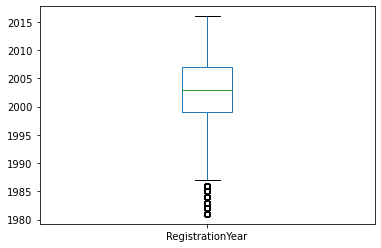

In [7]:
data.plot(y='RegistrationYear', kind='box')

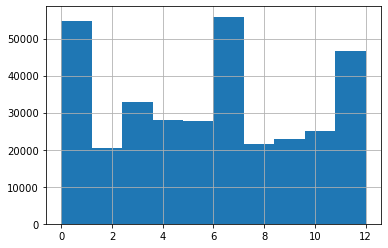

In [8]:
data['RegistrationMonth'].hist()

Данные выглядят нормально. Но месяц регистрации мы использовать не будем, а год - будем.

### Gearbox

In [9]:
data['Gearbox'].isna().sum()

16944

Пропусков много... Жаль, потому что тип коробки определённо влияет на стоимость автомобиля.</br>
Но заполнить пропуски нечем.

### Power

Ограничиваем порог валидных значений:
* min: 50 л.с. (Daewoo Matiz)
* 500 л.с. (Lamborgini) :))

In [10]:
# уберём из списка хвосты
data = data.query('50<Power<500')

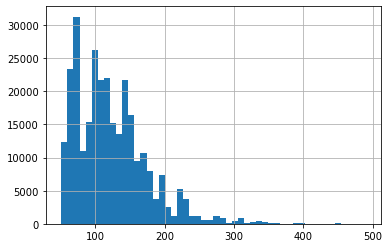

In [11]:
data['Power'].hist(bins=50)

### Model

In [12]:
#look Nan
data['Model'].isna().sum()

10789

Терять пропуски жалко. Заполним их 'noname'.

In [13]:
data['Model']=data['Model'].fillna('noname')

### Kilometer

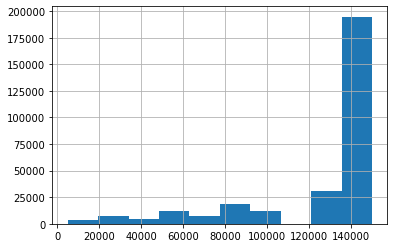

In [14]:
data['Kilometer'].hist(bins=10)

Вроде ничего страшного, пропусков тоже нет. Данные выглядят немного странно, будто они являются категориальными. Но использоваться они будут как скалярные.

### FuelType

In [15]:
data['FuelType'].value_counts()

petrol      181802
gasoline     88021
lpg           4751
cng            482
hybrid         201
other           55
electric        33
Name: FuelType, dtype: int64

Petrol и Gasoline - это на самом деле бензин, топливо одинаковое. Вероятно, объявления аггрегировались из разных стран, где бензин называют по-разному.<br/>
Было бы логично объединить эти категории.<br/>
Однако, если наша модель будет учитывать эту особенность для предсказания цены - будет прикольно! Так что оставим их разными классами.

In [16]:
data['FuelType'].isna().sum()

15516

А вот с пропусками ничего не поделаешь...

### Brand

In [17]:
data['Brand'].value_counts()

volkswagen        61566
bmw               32847
opel              31710
mercedes_benz     27365
audi              26171
ford              20156
renault           13964
peugeot            9259
fiat               7373
seat               5328
skoda              4962
mazda              4775
citroen            4170
nissan             4047
toyota             4024
smart              3526
hyundai            3124
mini               2964
volvo              2833
mitsubishi         2565
honda              2428
kia                2126
alfa_romeo         1980
suzuki             1929
chevrolet          1394
sonstige_autos     1272
chrysler           1188
dacia               804
subaru              657
porsche             590
jeep                559
daihatsu            554
saab                478
land_rover          450
jaguar              426
daewoo              406
rover               380
lancia              364
lada                141
trabant               6
Name: Brand, dtype: int64

Бренд должен оказывать влияние на цену авто. Поэтому считаем его категориальными признаками.<br/>

### NotRepaired

In [18]:
data['NotRepaired'].isna().sum()

42438

Многовато пропусков. Потерять объявления было бы жалко.
Но т.к. ремонт-важный признак, введём новую категорию, куда отнесём не указанные - 'NA'.

In [19]:
data['NotRepaired'] = data['NotRepaired'].fillna('NA')
data['NotRepaired'].value_counts()

no     219682
NA      42438
yes     28741
Name: NotRepaired, dtype: int64

In [20]:
data['DateCreated'].isna().sum()

0

### Price

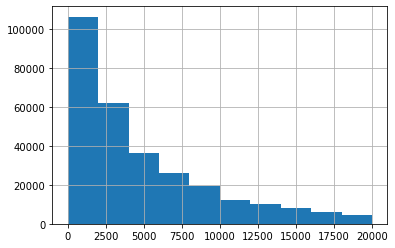

In [21]:
data['Price'].hist()

Уберем объявления, о дарении машин (цена ==0)

In [22]:
data = data.query('Price != 0')

Столбцы "DateCreated, NumberOfPictures, PostalCode, LastSeen" не влияют на стоимость авто, и не содержат пропусков.

Все пропущенные значения, где это было целесообразно, были обработаны. Поэтому для итоговых данных отбросим объявления с пропусками.

In [23]:
# отбрасываем объявления с пропусками
data = data.dropna()

Датасет с валидными для обучения данными готов! Кол-во объектов уменьшилось, но их всё равно ещё много!

Продолжаем обработку. Выделим значимые признаки для обучения моделей.<br/>

In [24]:
#categorical features
cat_features=['VehicleType', 'Gearbox', 'FuelType', 'Brand', 'NotRepaired']

#numeric features
num_features=['RegistrationYear','Power','Kilometer']

Следующие признаки использоваться не будут. В принципе очевидно всё. "Модель" не используем по двум причинам: 1. Отсутствие знания "модели авто" позволит лучше понять зависимость ценового сегмента авто от более значимых параметров(год выпуска, пробег).  2. Слишком много категорий - сложная машинная модель, низкие характеристики.

In [25]:
df = data.drop(['DateCrawled', 'Model', 'RegistrationMonth', 'DateCreated', 'NumberOfPictures','PostalCode', 'LastSeen'], axis=1)

Здесь мы разделим датасет.<br/>
Для df- закодируем категориальные признаки через ОНЕ.
Для df_cat - оставим без изменений. 

In [27]:
df_cat = df
df_cat.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 266775 entries, 1 to 354368
Data columns (total 9 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   Price             266775 non-null  int64 
 1   VehicleType       266775 non-null  object
 2   RegistrationYear  266775 non-null  int64 
 3   Gearbox           266775 non-null  object
 4   Power             266775 non-null  int64 
 5   Kilometer         266775 non-null  int64 
 6   FuelType          266775 non-null  object
 7   Brand             266775 non-null  object
 8   NotRepaired       266775 non-null  object
dtypes: int64(4), object(5)
memory usage: 20.4+ MB


### Кодирование признаков OHE

In [28]:
df = pd.get_dummies(df,columns=cat_features)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 266775 entries, 1 to 354368
Data columns (total 64 columns):
 #   Column                   Non-Null Count   Dtype
---  ------                   --------------   -----
 0   Price                    266775 non-null  int64
 1   RegistrationYear         266775 non-null  int64
 2   Power                    266775 non-null  int64
 3   Kilometer                266775 non-null  int64
 4   VehicleType_bus          266775 non-null  uint8
 5   VehicleType_convertible  266775 non-null  uint8
 6   VehicleType_coupe        266775 non-null  uint8
 7   VehicleType_other        266775 non-null  uint8
 8   VehicleType_sedan        266775 non-null  uint8
 9   VehicleType_small        266775 non-null  uint8
 10  VehicleType_suv          266775 non-null  uint8
 11  VehicleType_wagon        266775 non-null  uint8
 12  Gearbox_auto             266775 non-null  uint8
 13  Gearbox_manual           266775 non-null  uint8
 14  FuelType_cng             266775 non-

Разбиваем на трейн\тест и нормируем численные признаки.

In [29]:
target = df['Price']
df_features=df.drop(['Price'], axis=1)

features_train, features_test, target_train, target_test = train_test_split(df_features,target, test_size=0.25)
print('Features train:', features_train.shape)
print('Features test:', features_test.shape)
print('Target train:', target_train.shape)
print('Target test:', target_test.shape)

Features train: (200081, 63)
Features test: (66694, 63)
Target train: (200081,)
Target test: (66694,)


In [30]:
# scaling using StandartScaler
scaler=StandardScaler()
scaler.fit(features_train[num_features])

StandardScaler()

In [31]:
features_train_scaled = features_train
features_test_scaled = features_test

features_train_scaled[num_features]=scaler.transform(features_train[num_features])
features_test_scaled[num_features]=scaler.transform(features_test[num_features])

<ipython-input-31-7493056fee75>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  features_train_scaled[num_features]=scaler.transform(features_train[num_features])
/home/anticore/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
<ipython-input-31-7493056fee75>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats i

## Выводы

На вход получены выгрузки объявлений о продажи автомобилей. <br/>
Данные были проанализированы на наличие выбросов и пропусков. И те и другие были обработаны <br/>
Для целей обучения модели предсказания цены автомобиля, были выбраны значимые признаки:
* Категориальные:
    * 'VehicleType'
    * 'Gearbox'
    * 'FuelType'
    * 'Brand'
    * 'NotRepaired'
* Численные:
    * 'RegistrationYear'
    * 'Power'
    * 'Kilometer'
Целевой признак - 'Price'. <br/>

Категориальные признаки были закодированы ОНЕ. Численные признаки были отнормированы, используя StandardScaler.<br/>
Итоговые данные были разбиты на обучающую и тренировочную выборку(4:1). Размеры выборок:
* Features train: (200081, 63)
* Features test: (66694, 63)
* Target train: (200081,)
* Target test: (66694,)

# 2. Обучение моделей

Рассмотрим разные модели и оценим их по характерискам, интересным Заказчику:
* качество предсказания (RMSE)
* скорость предсказания
* время обучения


In [32]:
# функция строит предсказания на тестовой сборке и выдаёт скоры модели
def score_me(model):

    fit_t = %timeit -r 2 -o model.fit(features_train_scaled, target_train)

    pred_t = %timeit -r 2 -o model.predict(features_test_scaled)
    pred=model.predict(features_test)

    r2=r2_score(target_test,pred)
    mse=mean_squared_error(target_test,pred)
    rmse=mse**0.5

    result = {
        'Fit_time':fit_t.best,
        'Pred_time':pred_t.best,
        'RMSE':rmse
    }

    print('SCORING DONE')
    return result

### 2.1 Constant model

In [33]:
# посчитаем метрику медианной модели
median_target = target_train.median()
median_pred = np.full((target_test.shape),median_target)

rmse_const = (mean_squared_error(target_test, median_pred))**0.5
print('RMSE const. model(median predictions):', rmse_const)

RMSE const. model(median predictions): 4924.921833977264


In [34]:
result = pd.DataFrame(columns=['Fit_time','Pred_time', 'RMSE'])
result.loc['Const'] = [0.01,0.01,rmse_const]
result

,Fit_time,Pred_time,RMSE
Const,0.01,0.01,4924.921834


### 2.2 DecisionTreeRegressor

In [35]:
# функция гридсерч для дерева
def DTR_grid(feat, targ):
    estimator = DecisionTreeRegressor(random_state=112211)
    param_grid = {
            "max_depth" : [i for i in range(4,15,2)],
            "min_samples_leaf" : [i for i in range(1,20,5)],
            "min_samples_split" : [2,4,8],
            "max_features"      : ["auto", "sqrt", "log2"],
                }

    rfr_grid = GridSearchCV(estimator, param_grid, n_jobs=-1, cv=5, scoring='neg_root_mean_squared_error')
    rfr_grid.fit(feat, targ)

    print('...Search completed...')
    print('Best RMSE score', rfr_grid.best_score_)
    print('Best params:', rfr_grid.best_params_)

    return rfr_grid.best_params_

In [36]:
# получаем лучшие параметры дерева
#dtr_params = DTR_grid(features_train_scaled,target_train)
dtr_params = {'max_depth': 14, 'max_features': 'auto', 'min_samples_leaf': 6, 'min_samples_split': 2}

In [37]:
model_DTR=DecisionTreeRegressor(**dtr_params)

In [38]:
#применяем функцию скоринга к модели
DTR_scores = score_me(model_DTR)

897 ms ± 6.67 ms per loop (mean ± std. dev. of 2 runs, 1 loop each)
19.2 ms ± 112 µs per loop (mean ± std. dev. of 2 runs, 100 loops each)
SCORING DONE


In [39]:
# добавляем деревяные скоры
result.loc['DTR'] = DTR_scores
result

,Fit_time,Pred_time,RMSE
Const,0.010000,0.010000,4924.921834
DTR,0.890421,0.019057,1796.447474


### 2.3 RandomForestRegressor

In [40]:
# функция для обучения gridsearch
def RFR_grid(feat, targ):
    estimator = RandomForestRegressor(random_state=112211)
    param_grid = {
            "n_estimators"      : [10,20,30],
            "max_features"      : ["auto", "sqrt", "log2"],
            "max_depth" : [5,10,15],
            "min_samples_leaf" : [1, 4, 8],
            "min_samples_split" : [4,8,12],
            "bootstrap": [True, False],
                }

    rfr_grid = GridSearchCV(estimator, param_grid, n_jobs=-1, cv=5, scoring='neg_root_mean_squared_error')
    rfr_grid.fit(feat, targ)

    print('...Search completed...')
    print('Best RMSE score', rfr_grid.best_score_)
    print('Best params:', rfr_grid.best_params_)

    return rfr_grid.best_params_

In [41]:
#RFR_params = RFR_grid(features_train_scaled, target_train)

RFR_params = {'bootstrap': True,
              'max_depth': 15,
              'max_features': 'auto',
              'min_samples_leaf': 1,
              'min_samples_split': 4,
              'n_estimators': 30}

In [42]:
# best params
model_RFR = RandomForestRegressor(**RFR_params)

In [43]:
# scoring
RFR_score = score_me(model_RFR)

19.3 s ± 1.18 s per loop (mean ± std. dev. of 2 runs, 1 loop each)
267 ms ± 6.47 ms per loop (mean ± std. dev. of 2 runs, 1 loop each)
SCORING DONE


In [44]:
# update result df
result.loc['RFR'] = RFR_score
result

,Fit_time,Pred_time,RMSE
Const,0.010000,0.010000,4924.921834
DTR,0.890421,0.019057,1796.447474
RFR,18.113384,0.260964,1655.448481


### 2.4 LinearRegression

In [45]:
model_LR=LinearRegression()

In [46]:
LR_score = score_me(model_LR)

316 ms ± 508 µs per loop (mean ± std. dev. of 2 runs, 1 loop each)
10 ms ± 37.5 µs per loop (mean ± std. dev. of 2 runs, 100 loops each)
SCORING DONE


In [47]:
result.loc['Skl_LR'] = LR_score
result

,Fit_time,Pred_time,RMSE
Const,0.010000,0.010000,4924.921834
DTR,0.890421,0.019057,1796.447474
RFR,18.113384,0.260964,1655.448481
Skl_LR,0.315756,0.010003,2539.962946


### 2.5 XGBoost

Будем использовать класс XGBRegressor, встроенный в библиотеку.

In [48]:
def XGB_cv_grid():
    xgb_m = xgb.XGBRegressor(random_state=112211)
    param_grid = {
            "n_estimators"      : [100],
            "learning_rate"     : [0.1],
            "max_depth" : [20],
            "gamma" : [0.1],
            "reg_lambda": [5,10,20],
            "min_child_weight" : [4]
            }

    xgb_grid = GridSearchCV(xgb_m, param_grid, n_jobs=-1, cv=5, scoring='neg_root_mean_squared_error')
    xgb_grid.fit(features_train_scaled, target_train)

    print('...Search completed...')
    return xgb_grid.best_params_

In [49]:
#xgb_params = XGB_cv_grid()
#xgb_params

In [50]:
xgb_params ={'gamma': 0.1,
             'learning_rate': 0.1,
             'max_depth': 20,
             'min_child_weight': 4,
             'n_estimators': 100,
             'reg_lambda': 15}

In [51]:
xgb_model = xgb.XGBRegressor(**xgb_params)

In [52]:
xgbr_score = score_me(xgb_model)

28.7 s ± 2.2 s per loop (mean ± std. dev. of 2 runs, 1 loop each)
273 ms ± 484 µs per loop (mean ± std. dev. of 2 runs, 1 loop each)
SCORING DONE


In [53]:
result.loc['XGBR']= xgbr_score
result

,Fit_time,Pred_time,RMSE
Const,0.010000,0.010000,4924.921834
DTR,0.890421,0.019057,1796.447474
RFR,18.113384,0.260964,1655.448481
Skl_LR,0.315756,0.010003,2539.962946
XGBR,26.527501,0.272452,1533.840991


### 2.6 LightGBM

In [54]:
def LGB_cv_grid():
    lgb_m = lgb.LGBMRegressor(random_state=112211)
    param_grid = {
            "num_leaves"        : [500,1000],
            "learning_rate"     : [0.1],
            "max_depth" : [-1],
            "reg_lambda": [1,5],
            "min_child_weight" : [1,5]
            }

    lgb_grid = GridSearchCV(lgb_m, param_grid, n_jobs=-1, cv=5, scoring='neg_root_mean_squared_error')
    lgb_grid.fit(features_train_scaled,target_train)

    print('...Search completed...')
    return lgb_grid.best_params_

In [55]:
#lgb_params = LGB_cv_grid()
lgb_params = {'learning_rate': 0.1,
              'max_depth': -1,
              'min_child_weight': 1,
              'num_leaves': 1000,
              'reg_lambda': 5}

In [56]:
lgb_model = lgb.LGBMRegressor(**lgb_params)

In [57]:
lgb_score = score_me(lgb_model)
result.loc['LightGBM'] = lgb_score
result

2.8 s ± 102 ms per loop (mean ± std. dev. of 2 runs, 1 loop each)
284 ms ± 583 µs per loop (mean ± std. dev. of 2 runs, 1 loop each)
SCORING DONE


,Fit_time,Pred_time,RMSE
Const,0.010000,0.010000,4924.921834
DTR,0.890421,0.019057,1796.447474
RFR,18.113384,0.260964,1655.448481
Skl_LR,0.315756,0.010003,2539.962946
XGBR,26.527501,0.272452,1533.840991
LightGBM,2.696459,0.283272,1536.024552


## 2.7 CatBoost

Яндекс грозится, что СВ - супер-пупер обучатель категориальных признаков. Ну чтож попробуем! Для СВ будем использовать отдельный датасет, где категориальные признаки необработаны.

In [58]:
# готовим выборки
target_cat = df_cat['Price']
df_features_cat=df_cat.drop(['Price'], axis=1)

features_train_cat, features_test_cat, target_train_cat, target_test_cat = train_test_split(df_features_cat,target_cat, test_size=0.25)
print('Features train:', features_train_cat.shape)
print('Features test:', features_test_cat.shape)
print('Target train:', target_train_cat.shape)
print('Target test:', target_test_cat.shape)

Features train: (200081, 8)
Features test: (66694, 8)
Target train: (200081,)
Target test: (66694,)


In [59]:
# пулы
train_pool = cb.Pool(features_train_cat,
                     target_train_cat,
                     cat_features = cat_features)

test_pool = cb.Pool(features_test_cat, cat_features=cat_features)

In [60]:
def CB_cv_grid():
    cb_m = cb.CatBoostRegressor(random_state=112211)

    param_grid = {
            "iterations"        : [500,1000,2000],
            "learning_rate"     : [0.1,1],
            "depth" : [1,5]
            }

    cb_grid = GridSearchCV(cb_m, param_grid, n_jobs=-1, cv=5, scoring='neg_root_mean_squared_error')
    cb_grid.fit(features_train_cat, target_train_cat, cat_features=cat_features, verbose=False)

    print('...Search completed...')
    return cb_grid.best_params_

In [61]:
#cb_params=CB_cv_grid()
cb_params = {'depth': 6, 'iterations': 2000, 'learning_rate': 0.4, 'loss_function':'RMSE'}

In [62]:
model_cb = cb.CatBoostRegressor(**cb_params, verbose=False)

In [63]:
cb_score = score_me(model_cb)
result.loc['CatBoost'] = cb_score
result.loc['CatBoost']

15.7 s ± 109 ms per loop (mean ± std. dev. of 2 runs, 1 loop each)
20.5 ms ± 297 µs per loop (mean ± std. dev. of 2 runs, 10 loops each)
SCORING DONE


Fit_time       15.629048
Pred_time       0.020182
RMSE         1544.531451
Name: CatBoost, dtype: float64

Лааадно, Яндекс! Хорошие результаты!))

## 3. Анализ моделей

Посмотрим на итоговые результаты.

In [64]:
result

,Fit_time,Pred_time,RMSE
Const,0.010000,0.010000,4924.921834
DTR,0.890421,0.019057,1796.447474
RFR,18.113384,0.260964,1655.448481
Skl_LR,0.315756,0.010003,2539.962946
XGBR,26.527501,0.272452,1533.840991
LightGBM,2.696459,0.283272,1536.024552
CatBoost,15.629048,0.020182,1544.531451


<ipython-input-65-86e3068567be>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  plot_df['Model']=plot_df.index


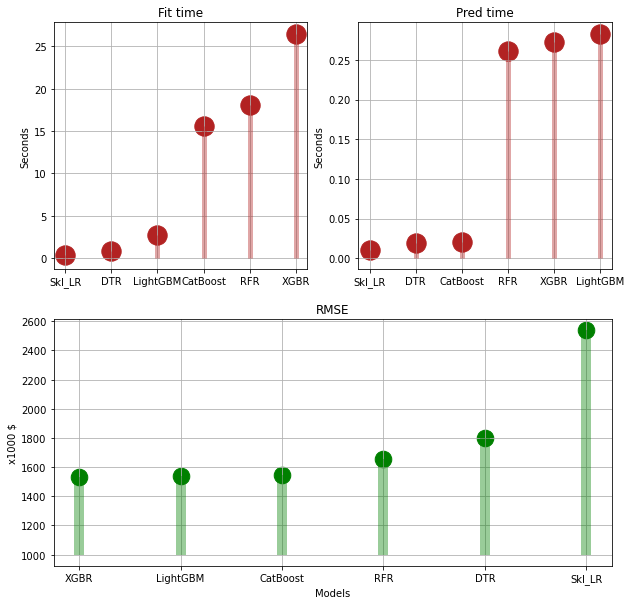

In [65]:
plot_df=result.loc['DTR':]
plot_df['Model']=plot_df.index

fig = plt.figure(figsize=(10,10))
ax1=fig.add_subplot(2,2,1)
ax2=fig.add_subplot(2,2,2)
ax3=fig.add_subplot(2,1,2)

# FIT-time plot
plot_df = plot_df.sort_values(by='Fit_time',ascending=True)
ax1.vlines(x=plot_df['Model'], ymin=0, ymax=plot_df['Fit_time'], color='firebrick', linewidth=5, alpha=0.4)
ax1.scatter(x=plot_df['Model'], y=plot_df['Fit_time'], s=375, color='firebrick')
ax1.grid()
ax1.set_ylabel('Seconds')
ax1.set_title('Fit time')

#Pred-time plot
plot_df = plot_df.sort_values(by='Pred_time',ascending=True)
ax2.vlines(x=plot_df['Model'], ymin=0, ymax=plot_df['Pred_time'], color='firebrick', linewidth=5, alpha=0.4)
ax2.scatter(x=plot_df['Model'], y=plot_df['Pred_time'], s=375, color='firebrick')
ax2.grid()
ax2.set_ylabel('Seconds')
ax2.set_title('Pred time')

# RMSE
plot_df = plot_df.sort_values(by='RMSE',ascending=True)
ax3.vlines(x=plot_df['Model'], ymin=1000, ymax=plot_df['RMSE'], color='green', linewidth=10, alpha=0.4)
ax3.scatter(x=plot_df['Model'], y=plot_df['RMSE'], s=275, color='green')
ax3.grid()
ax3.set_ylabel('x1000 $')
ax3.set_xlabel('Models')
ax3.set_title('RMSE')
plt.show()

Из графиков видно, что базовые модели дерева и лин.регрессии работают быстро, но вот с точностью предсказаний - не очень. Бустеры работают медленно, но существенно улучшают качество предсказания. </br>

Введём простенький скоринг для полученных результатов. Т.к. чем больше полученные показатели каждой модели - тем хуже (скорость или RMSE), дадим 1 штрафной балл самой медленной или ошибающейся модели, и 0 баллов самой быстрой или точной соответственно. Штрафные баллы для других моделей расчитаем в долях на этой шкале (0,1):<br/>
$penalty=\frac{x-x_{\min}}{x_{\max}-x_{\min}}$

Меньше штрафных баллов - лучше. Ну и если считать все параметры равнозначными, сложим штрафы по всем трём показателям и посмотрим финальный скор.

In [66]:
top_mx=pd.DataFrame(index=plot_df.index)
for col in ['Fit_time', 'Pred_time', 'RMSE']:
    max=plot_df[col].max()
    min=plot_df[col].min()
    top_mx[col] = (plot_df[col]-min)/(max-min)

top_mx['final'] = top_mx.sum(axis=1)
print('Penalty scores')
top_mx = top_mx.sort_values('final')
top_mx

Penalty scores


,Fit_time,Pred_time,RMSE,final
DTR,0.021924,0.033132,0.261009,0.316065
CatBoost,0.584215,0.037250,0.010625,0.632090
Skl_LR,0.000000,0.000000,1.000000,1.000000
LightGBM,0.090826,1.000000,0.002170,1.092996
RFR,0.678994,0.918368,0.120868,1.718230
XGBR,1.000000,0.960405,0.000000,1.960405


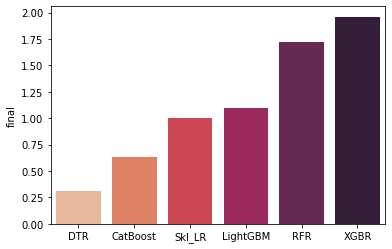

In [67]:
sns.barplot(x=top_mx.index, y="final", data=top_mx, palette="rocket_r")

Дерево всех забороло!)) На самом деле, необходимо выбрать более адекватную оценку моделей вместе с Заказчиком.

# Выводы

Целью работы было нахождение оптимальной модели для предсказания цены автомобиля по следующим параметрам:
* качество предсказания (RMSE)
* скорость предсказания
* время обучения

Входными данными была выгрузка объявлений о продаже автомобилей (около 300к.). Данные были обработаны. В качестве значимых признаков для обучения моделей были выбраны следующие:
* Категориальные:
    * 'VehicleType'
    * 'Gearbox'
    * 'FuelType'
    * 'Brand'
    * 'NotRepaired'
* Численные:
    * 'RegistrationYear'
    * 'Power'
    * 'Kilometer'

Проведёно обучение и анализ разных моделей. Для каждой подбирались лучшие гиперпараметры, исходя из задачи минимизации MSE.<br/>
Для перспективных моделей проведено обучение с замером лучшего времени обучения(best of 2).
Для предсказания также было посчитано время исполнения. В качестве метрики качества использовалась RMSE.<br/>
Итоговые результаты:

In [69]:
result.round(2)

,Fit_time,Pred_time,RMSE
Const,0.01,0.01,4924.92
DTR,0.89,0.02,1796.45
RFR,18.11,0.26,1655.45
Skl_LR,0.32,0.01,2539.96
XGBR,26.53,0.27,1533.84
LightGBM,2.70,0.28,1536.02
CatBoost,15.63,0.02,1544.53


Учитывая все три показателя (время обучения, предсказания и RMSE) равновесно, оптимальной моделью является DecisionTreeRegressor. Она быстрая и даёт приемлемую точность.<br/>
Однако, логичнее было бы считать точность предсказания более весомой характеристикой. Модели бустинга показали существенно лучшие метрики точности предсказания, следовательно рекомендуется выбрать одну из них, самую быструю. В данном случае - LightGBM.